In [1]:
import sys
sys.path.append("/home/amisery/SemesterProject")
from models.engine_nodecl import NodeClassificationEngine
from data.sfgd_datamodules import NodeCL_h5dataset
from models.model_utils import *
from data.plotting_utils import *
import matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
ckpt_path_wide = "/home/amisery/SemesterProject/tb_logs/my_model/version_35/checkpoints/epoch=92-step=19065.ckpt"
ckpt_path_deep = "/home/amisery/SemesterProject/tb_logs/my_model/version_56/checkpoints/epoch=63-step=13120.ckpt"
ckpt_path_deep = "/home/amisery/SemesterProject/tb_logs/my_model/version_50/checkpoints/epoch=49-step=10250.ckpt"
ckpt_path_small = "/home/amisery/SemesterProject/tb_logs/my_model/version_68/checkpoints/epoch=57-step=11890.ckpt"
ckpt_path_fweight = "/home/amisery/SemesterProject/tb_logs/my_model/version_2/checkpoints/epoch=47-step=9840.ckpt"
model = NodeClassificationEngine.load_from_checkpoint(ckpt_path_deep, map_location="cpu", strict=False)

In [76]:
dataset_h5 = NodeCL_h5dataset("/scratch/.amisery/out_cap_2000.h5")
dataset_h5_1000 = NodeCL_h5dataset("/scratch/.amisery/out_cap_1000.h5")

In [5]:
torch.sum(get_attention_from_data(model, dataset_h5,3)[0,3,:])

tensor(1., grad_fn=<SumBackward0>)

In [6]:
def display_3D_from_coords_labels(coords, vals,ax):
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    
    for i in range(1,4):
        cat_coords =coords[(vals==i).squeeze(1),:]
        plot = ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    return plot

In [79]:
def plot_truth_pred(dataset,model,idx):
    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,2,1,projection='3d')
    display_3D_from_coords_labels(dataset.get_raw(idx)['coords'][:,:3], dataset.get_raw(idx)["values"],ax)
    plt.title("Event #%d, %d hits, ground truth"%(idx, len(dataset.get_raw(idx)['coords'])), fontsize = 15)
    ax = fig.add_subplot(1,2,2,projection='3d')
    ax= display_3D_from_coords_labels(dataset.get_raw(idx)['coords'][:,:3], model_inference(model,dataset,idx),ax)
    plt.title("Model Prediction", fontsize = 15)
    # plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.3)

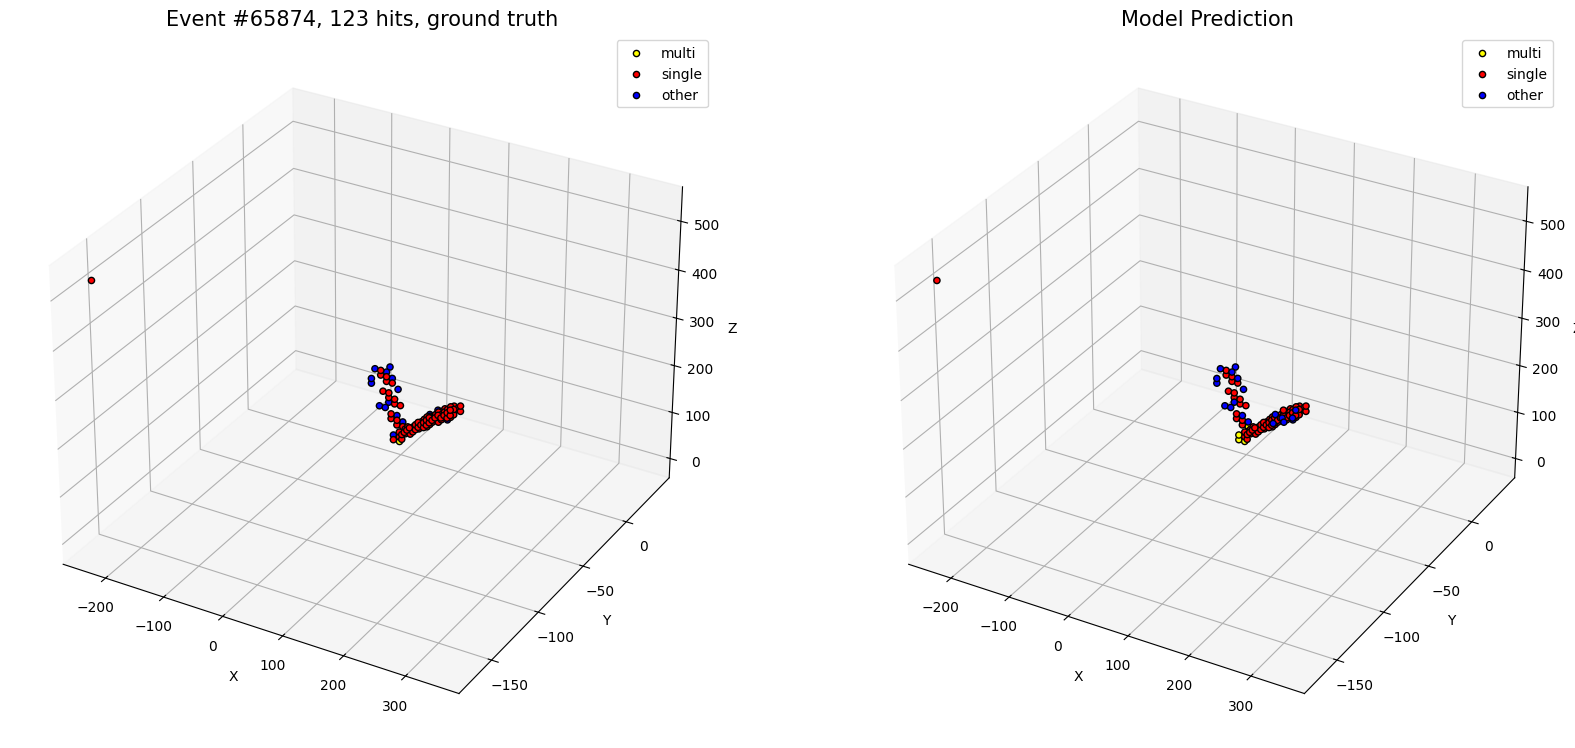

In [8]:
plot_truth_pred(dataset_h5,model,np.random.randint(len(dataset_h5)))37346

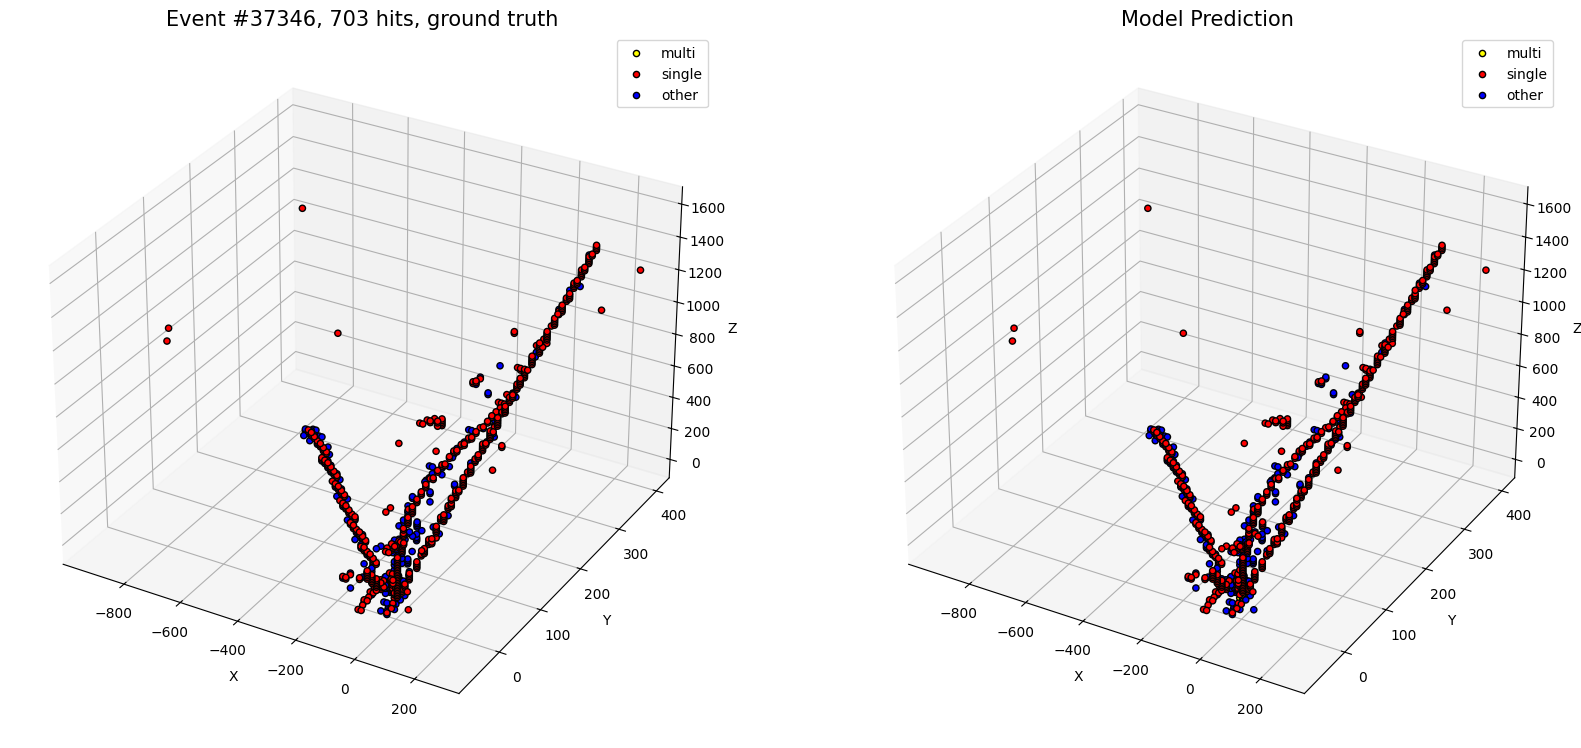

In [80]:
plot_truth_pred(dataset_h5_1000,model,37346)

In [9]:
print(dataset_h5.get_raw(3)['coords'][:,:3].size())

torch.Size([216, 3])


## Visualizing Attention

In [10]:
def plot_attention(ax,dataset,model, idx, ref_point):
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    coords = dataset.get_raw(idx)['coords'][:,:3]
    attn = get_attention_from_data(model,dataset,idx)
    at_pt = attn[:,ref_point,:].squeeze(0).detach().numpy()
    print(at_pt.shape)
   
    plot = ax.scatter(coords[:,0], coords[:,1], coords[:,2], c = at_pt, cmap = "viridis",edgecolor = "black", alpha = 1, zorder = -1)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.colorbar(plot, ax  = ax, use_gridspec= True,fraction=0.046, pad=0.04)
    h_s = ax.plot(coords[ref_point,0], coords[ref_point,1], coords[ref_point,2], c = "red", markersize = 15, markeredgewidth = 2, marker = 'x', zorder = 10)
    # h_s.set_offset_position('data')
    return plot

In [59]:
def plot_avg_attention(ax,dataset,model,idx):
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    coords = dataset.get_raw(idx)['coords'][:,:3]
    attn = get_attention_from_data(model,dataset,idx)
    print(attn.shape)
    plot = ax.scatter(coords[:,0], coords[:,1], coords[:,2], c =np.average(attn.detach().numpy(),axis=1), cmap = "viridis",edgecolor = "black", alpha = 1, zorder = -1)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.colorbar(plot, ax  = ax, use_gridspec= True,fraction=0.046, pad=0.04)
    # h_s = ax.plot(coords[ref_point,0], coords[ref_point,1], coords[ref_point,2], c = "red", markersize = 15, markeredgewidth = 2, marker = 'x', zorder = 10)
    # h_s.set_offset_position('data')
    plt.title("Average attention value for each point, event %d, %d hits"%(idx,len(coords)))
    return plot

In [11]:
def display_3D_charge(coords,charge,ax):   
    plot = ax.scatter(coords[:,0], coords[:,1], coords[:,2], c = charge.squeeze(0).detach().numpy(), cmap ="magma", edgecolor = "black", alpha = 1,norm=matplotlib.colors.LogNorm())
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Charge")
    plt.colorbar(plot, ax  = ax, use_gridspec= True,fraction=0.046, pad=0.04)
    return plot

In [12]:
def plot_attn_gtruth(dataset,model,idx,refpoint, mode = "labels"):
    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,2,1,projection='3d')
    labels = ["multi particle", "single particle", "noise"]
    print(np.where(dataset.get_raw(idx)["values"]==1))
    if mode == "labels":
        display_3D_from_coords_labels(dataset.get_raw(idx)['coords'][:,:3], dataset.get_raw(idx)["values"],ax)
    elif mode == "charge":
        display_3D_charge(dataset.get_raw(idx)['coords'][:,:3], dataset.get_raw(idx)["coords"][:,3],ax)
    else :
        raise(RuntimeError("Unkown Mode. Must be either charge or labels"))
    plt.title("Event #%d, %d hits, ground truth"%(idx, len(dataset.get_raw(idx)['coords'])), fontsize = 15)
    ax = fig.add_subplot(1,2,2,projection='3d')
    refpoint_cat = dataset.get_raw(idx)["values"][refpoint]
    print(refpoint_cat.item())
    
    ax= plot_attention(ax,dataset_h5, model, idx, refpoint)
    plt.title("Attention map for a %s hit, index %s"%(labels[int(refpoint_cat-1)],refpoint
    ), fontsize = 15)
    
    # plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([134, 138, 142, 143, 145, 157]), array([0, 0, 0, 0, 0, 0]))
2.0
(223,)


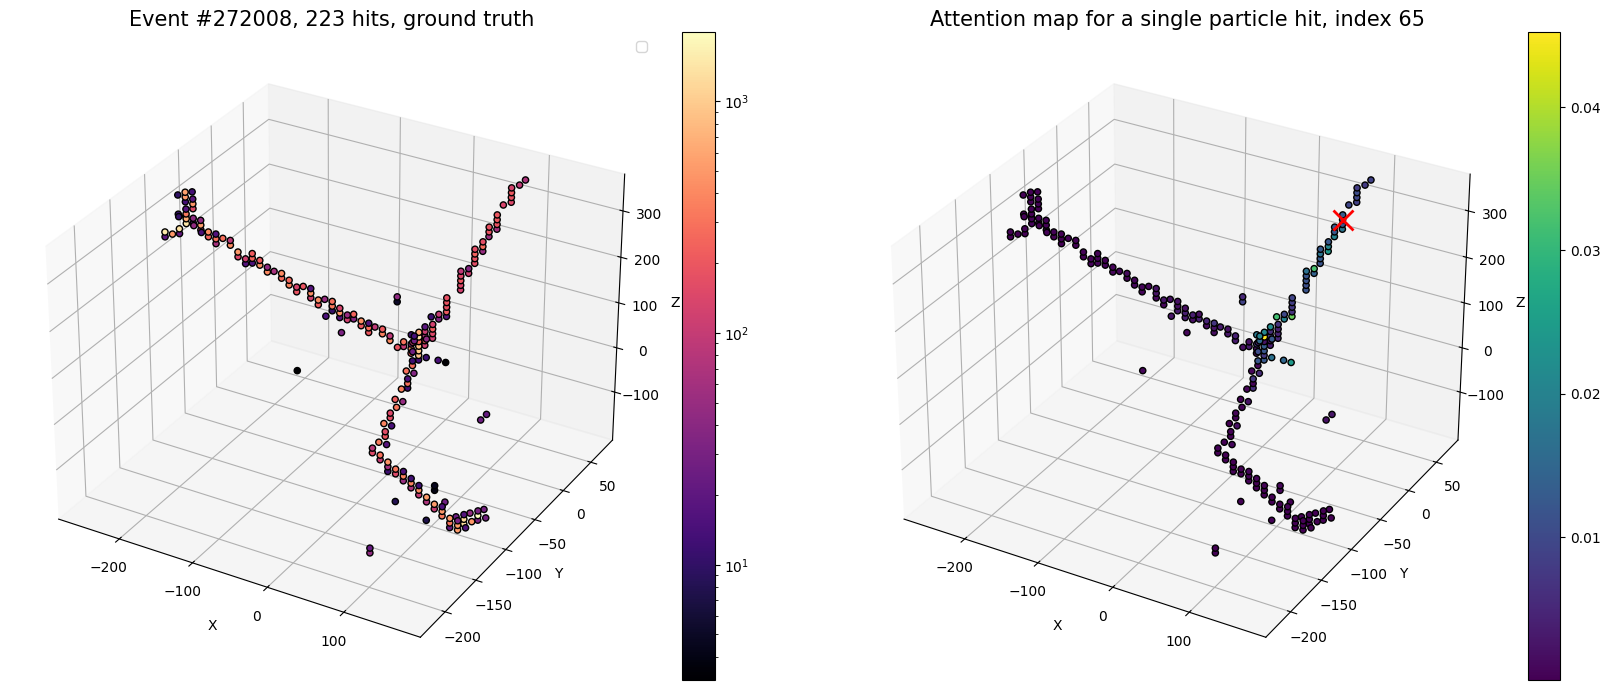

In [54]:

plot_attn_gtruth(dataset_h5,model,272008,65,mode="charge")

torch.Size([1, 171, 171])


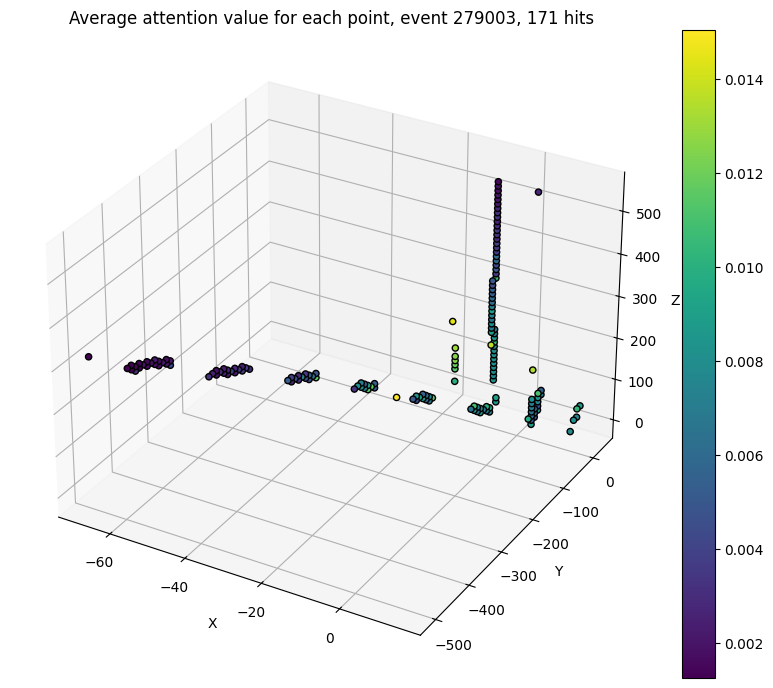

In [74]:
fig = plt.figure(figsize=(20,40))
ax = fig.add_subplot(1,2,1,projection='3d')

plot_avg_attention(ax,dataset_h5,model,279003)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([64, 65, 71]), array([0, 0, 0]))
1.0
(196,)
(array([64, 65, 71]), array([0, 0, 0]))
1.0
(196,)


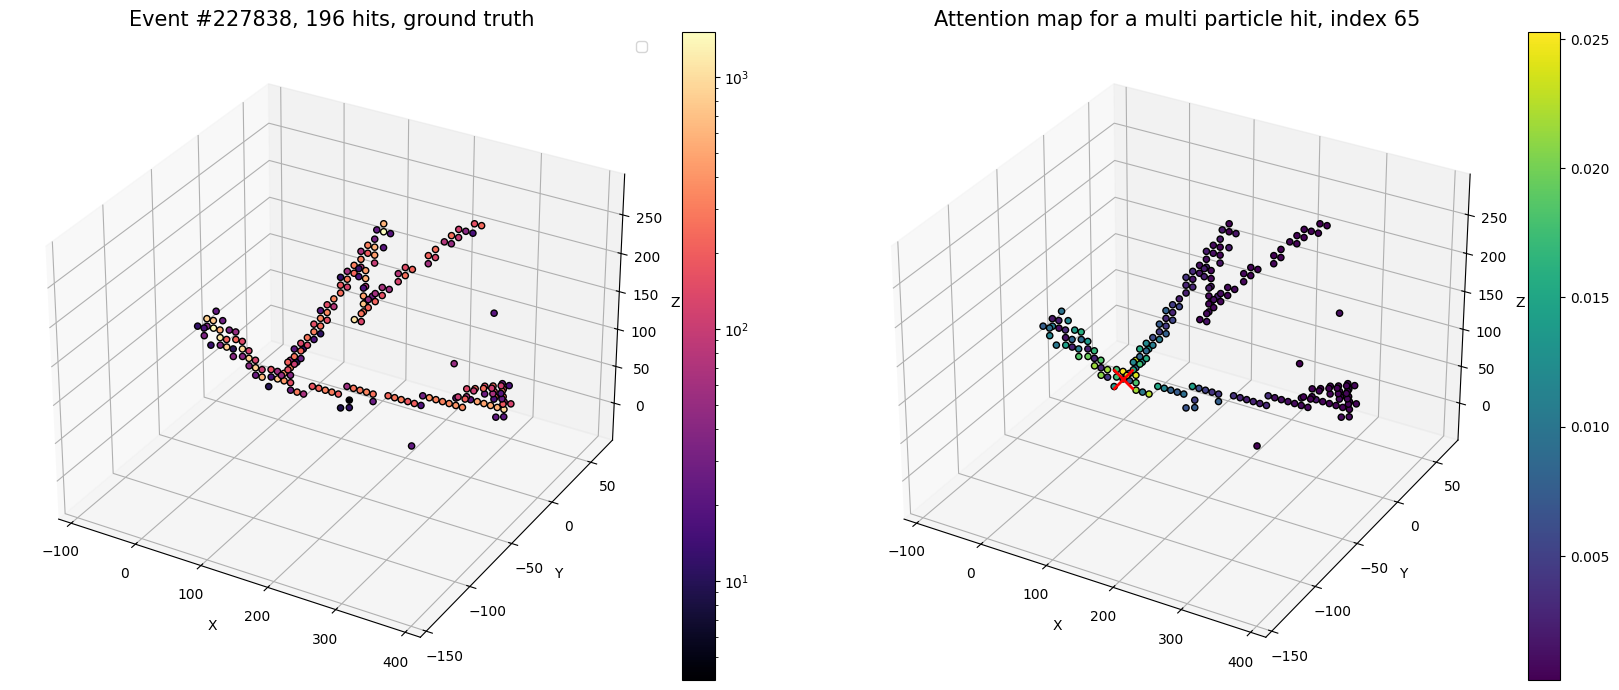

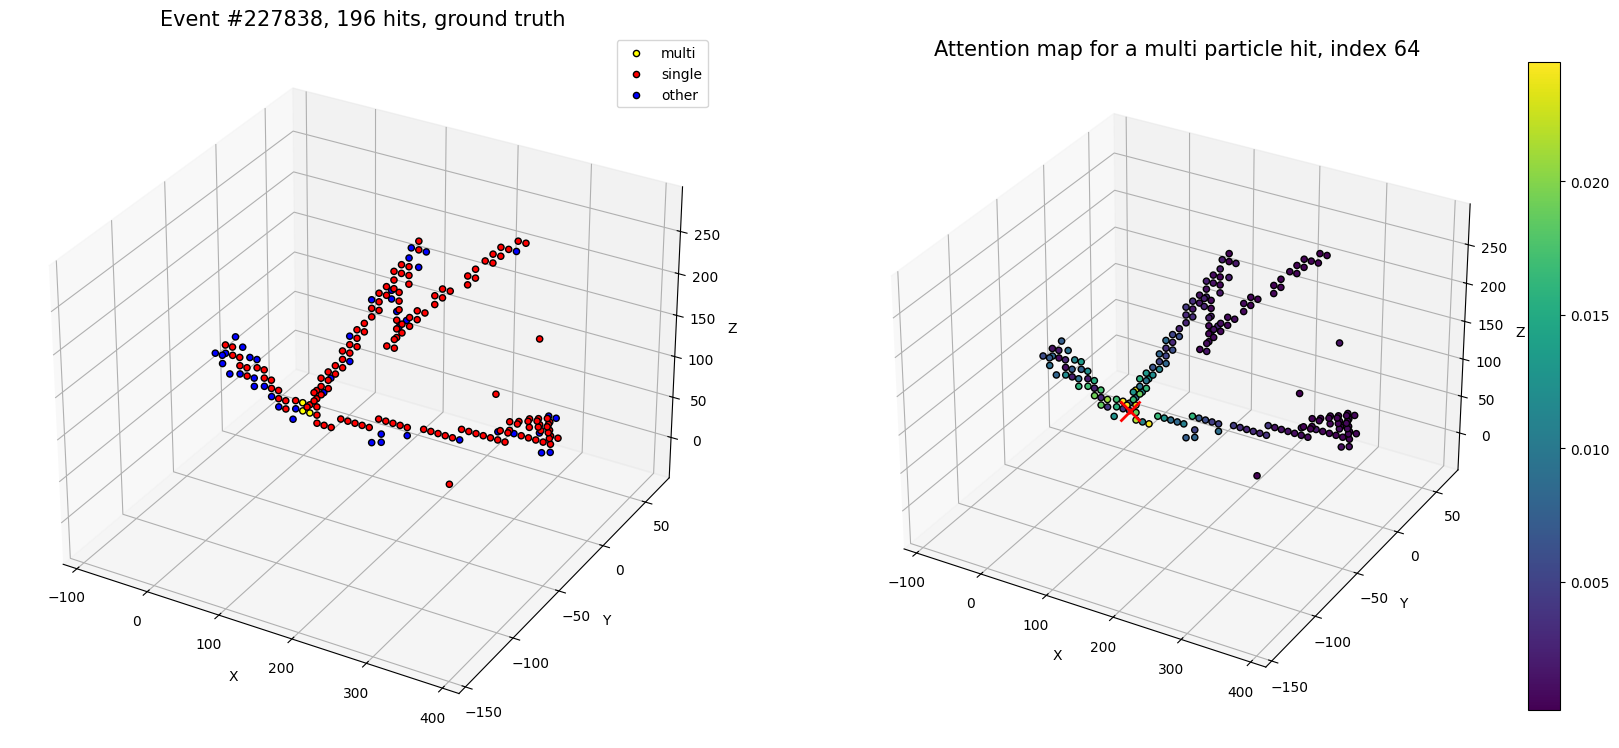

In [61]:
plot_attn_gtruth(dataset_h5,model,227838,65,mode="charge")
plot_attn_gtruth(dataset_h5,model,227838,64,mode="labels")